In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import process_location
import imp
import calendar
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import format_data
imp.reload(process_location)
imp.reload(format_data)
%matplotlib inline

In [66]:
folder = '/Users/alexandreattia/Desktop/Work/Practice/LocationHistory/LocationHistoryData/'
cookie_content = 'XXX'
process_location.create_kml_files('february', 1, 'may', 31, cookie_content, folder)
df = process_location.full_df(folder)

122 KML files (ie 122 days) to concatenate


## Stats 

In [69]:
# imp.reload(format_data)
# df_driving = format_data.time_at_doing(df, 'driving')
# df_work = format_data.time_at_place(df, 'Work')
# # Special, so not currently doable by the script
# df_home_all = df[(df.Address == 'Home')]
# df_home_week_day = df[(df.Address == 'Home') & (df.WeekDay < 5)]
# df_home_all['DurationMin'] = df_home_all['Duration'].apply(format_data.get_sec) / 60

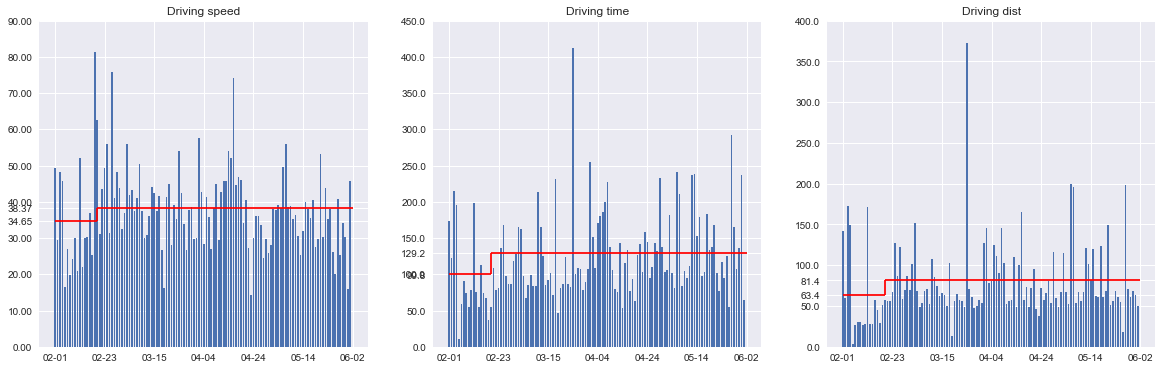

In [173]:
dicts = format_data.get_dict_doing(df_driving)
means = {t:[] for t in dicts}

width = 1/1.5
date_move_out = '2017-02-20'
index_move_out = sorted(dicts['time'].keys()).index(date_move_out)
f, ax = plt.subplots(ncols=3, figsize=(20,6))

for i, (name, dic) in enumerate(dicts.items()):
    x = range(len(dic.values()))
    means[name].append(np.mean([elem[1] for elem in sorted(dic.items())][:index_move_out]))
    means[name].append(np.mean([elem[1] for elem in sorted(dic.items())][index_move_out:]))
    ax[i].bar(x, [elem[1] for elem in sorted(dic.items())], width)
    ax[i].set_title('Driving %s' % name)
    ax[i].hlines(means[name][0], xmin=0, xmax=index_move_out, color="red")
    ax[i].hlines(means[name][1], xmin=index_move_out, xmax=len(dic.values()),  color="red")
    ax[i].vlines(x=index_move_out, 
                  ymin=means[name][0], 
                  ymax=means[name][1],  
                  color='r')
    ax[i].set_yticks(list(ax[i].get_yticks()) + [means[name][0], means[name][1]])
    xticks_labels = [sorted(dicts['time'])[int(k)][5:] for k in ax[0].get_xticks()[1:-2]]+[sorted(dicts['time'])[::-1][0][5:]]
    _ = ax[i].set_xticklabels(['']+xticks_labels)

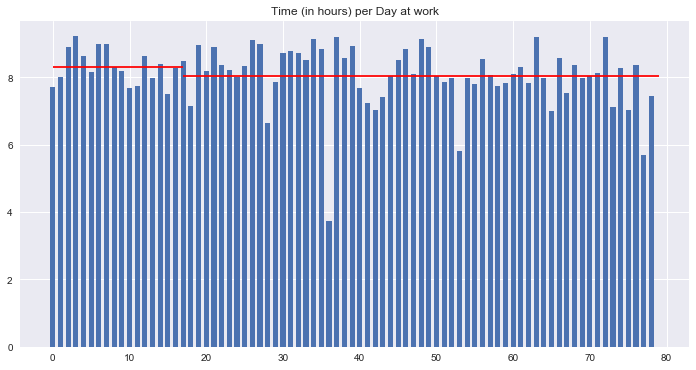

In [185]:
time_per_day_work = {}
for day in sorted(df_work['BeginDate']):
    time_per_day_work.update({day:df_work[df_work['BeginDate'] == day].DurationMin.sum() / 60})

x = range(len(time_per_day_work))
width = 1/1.5
mean_time_work_1 = np.mean([elem[1] for elem in sorted(time_per_day_work.items())][:index_move_out])
mean_time_work_2 = np.mean([elem[1] for elem in sorted(time_per_day_work.items())][index_move_out:])
plt.figure(figsize=(12,6))
plt.bar(x, [elem[1] for elem in sorted(time_per_day_work.items())], width)
plt.hlines(mean_time_work_1, xmin=0, xmax=index_move_out, color="red")
plt.hlines(mean_time_work_2, xmin=index_move_out, xmax=len(x),  color="red")
plt.title('Time (in hours) per Day at work')

In [211]:
a = pd.Series(pd.to_timedelta([elem for elem in df_work.BeginTime if elem < '10:30:00'])).mean().total_seconds()
b = pd.Series(pd.to_timedelta([elem for elem in df_work.EndTime if elem > '15:30:00'])).mean().total_seconds()
print("On average, I am at work from %s to %s" % (process_location.sec_to_time(a)[3],process_location.sec_to_time(b)[3]))

arriving_time = list(df_home_week_day[(df.BeginTime > '17:00:00') & (df.BeginTime < '21:00:00')].BeginTime)
departing_time = list(df_home_week_day[(df.EndTime > '07:00:00') & (df.EndTime < '10:00:00')].EndTime)
a = pd.Series(pd.to_timedelta(arriving_time)).mean().total_seconds()
b = pd.Series(pd.to_timedelta(departing_time)).mean().total_seconds()
print("On average, I am at home from %s to %s" % (process_location.sec_to_time(a)[3],process_location.sec_to_time(b)[3]))

On average, I am at work from 09:09:01 to 17:55:41
On average, I am at home from 18:59:07 to 08:30:01


/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Maps

### Generating Google Maps HTML plots

In [5]:
import gmplot

In [6]:
date = '2017-04-01'
concatenation = np.concatenate(list(df[df.BeginDate == date].Track))
longitudes, latitudes = [float(elem[0]) for elem in concatenation], [float(elem[1]) for elem in concatenation]

g = gmplot.GoogleMapPlotter(37.428, -122.145, 9)
g.scatter(latitudes, longitudes, 'b')
g.draw('scatter2.html')

In [279]:
number_of_days = 30
delta = datetime.strptime(df.loc[0, 'BeginDate'], '%Y-%m-%d') - timedelta(days=number_of_days)
concatenation = np.concatenate(list(df[df.BeginDate > delta.strftime("%Y-%m-%d")].Track))
longitudes, latitudes = [float(elem[0]) for elem in concatenation], [float(elem[1]) for elem in concatenation]

g = gmplot.GoogleMapPlotter(37.428, -122.145, 9)
g.heatmap(latitudes, longitudes)
g.draw('heatmap.html')

### Scatter plot

In [31]:
# San Francisco + San Mateo County
llcrnrlon_sf = -122.51608919999998 - 0.1
llcrnrlat_sf = 37.5421617 - 0.1
urcrnrlon_sf = -122.25853989999999 + 0.1
urcrnrlat_sf = 37.8718992 + 0.1
borders1 = (llcrnrlon_sf, llcrnrlat_sf, urcrnrlon_sf, urcrnrlat_sf)

# San Francisco
llcrnrlon_sf = -122.5051593 - 0.04
llcrnrlat_sf = 37.7331299 - 0.04
urcrnrlon_sf = -122.3864967 + 0.02
urcrnrlat_sf = 37.8201475 + 0.02
borders2 = (llcrnrlon_sf, llcrnrlat_sf, urcrnrlon_sf, urcrnrlat_sf)

In [32]:
restaurants = ['Restaurant', 'Cafe', 'Japanese', 'Sushi', 
               'Italian', 'American', 'Bakery', 'Mexican',
               'Californian Restaurant', 'Pizza', 'Greek',
               'French', 'Peruvian', 'Latin American Restaurant',
               'Asian Restaurant', 'Crêperie', 'Cocktail Bar']
stores = ["Clothing Store", "Shopping Mall", "Convenience Store",
         'Shoe Store', 'Women\'s Clothing Store', "Sportswear Store"]

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


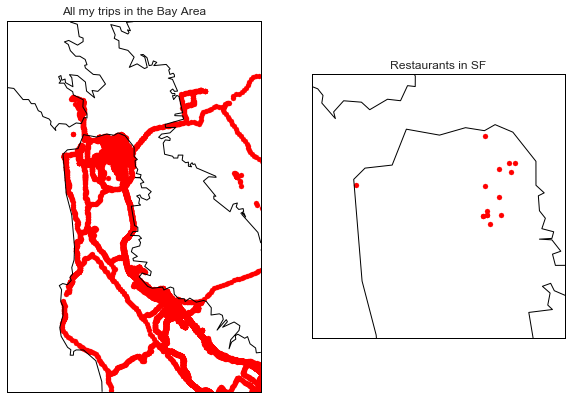

In [33]:
f, ax = plt.subplots(ncols=2, figsize=(10,15))
process_location.plot_basemap(df, borders1, ax=ax[0], title='All my trips in the Bay Area')
process_location.plot_basemap(df[df.Category.isin(restaurants)], borders2, ax=ax[1], title='Restaurants in SF')